In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from tqdm import tqdm

from scipy import stats

In [2]:
class RecurrentSpaceNet(torch.nn.Module):
    def __init__(self, n_in, n_out, scale = 0.4, device = "cpu", **kwargs):
        super().__init__(**kwargs)
        self.scale = scale
        self.device = device
        self.p0 = torch.nn.Sequential(
                torch.nn.Linear(2, 64),
                torch.nn.ReLU(),
                torch.nn.Linear(64, n_out),
                torch.nn.ReLU())

        self.spatial_representation = torch.nn.RNN(
            input_size = n_in,
            hidden_size = n_out,
            nonlinearity= "relu",
            bias=False,
            batch_first=True)        
        
        torch.nn.init.eye_(self.spatial_representation.weight_hh_l0) # identity initialization   
        self.to(device)
    
    def correlation_function(self, r):
        # Compare across time and samples
        rr = torch.reshape(r, (-1, 2)) # bs*ts, 2
        dr = torch.sum((rr[:,None] - rr[None])**2, dim = -1)
        correlation = torch.exp(-0.5/self.scale**2*dr) 
        return torch.triu(correlation, diagonal = 0) # save some computation
        
    def forward(self, inputs):
        # RNN returns representations and final hidden state
        initial_state = self.p0(inputs[1])
        p, _ = self.spatial_representation(inputs[0], initial_state[None])
        pcorr = torch.reshape(p, (-1, p.shape[-1])) # bsts, N
        corr = pcorr@torch.transpose(pcorr, dim0 = -1, dim1 = -2) # correlation matrix
        return torch.triu(corr, diagonal = 0)
    
    def train_step(self, x, y, optimizer):
        optimizer.zero_grad()
        loss = self.loss_fn(x, y)
        loss.backward()
        optimizer.step()
        return loss.item()
        
    def loss_fn(self, x, y):
        # x = inputs to model, y = labels
        corr = self(x)
        label_corr = self.correlation_function(y)
        loss = torch.mean((corr - label_corr)**2)
        return loss

In [3]:
# Simple test dataset maker; square box + bounce off walls

class DatasetMaker(object):
    def __init__(self, chamber_size = 1):
        self.chamber_size = chamber_size
        
    def bounce(self, r, v):
        outside = np.abs(r + v) >= self.chamber_size
        v[outside] = -v[outside]
        return v

    def generate_dataset(self, samples, timesteps, device = "cpu"):
        stddev = 4*np.pi # von Mises
        r = np.zeros((samples, timesteps, 2))

        s = np.random.rayleigh(0.025, (samples, timesteps))
        prev_hd = np.random.uniform(0, 2*np.pi, samples)
        r[:,0] = np.random.uniform(-self.chamber_size, self.chamber_size, (samples, 2)) 

        for i in range(timesteps - 1):
            hd = np.random.vonmises(prev_hd, stddev, samples)
            prop_v = s[:,i,None]*np.stack((np.cos(hd), np.sin(hd)),axis=-1)
            v = self.bounce(r[:,i], prop_v) 
            prev_hd = np.arctan2(v[:,1], v[:,0])
            r[:,i+1] = r[:,i] + v # dt = 1

        v = np.diff(r, axis = 1)
        
        return torch.tensor(r.astype('float32'), device = device), torch.tensor(v.astype('float32'), device = device)


In [4]:
## Training parameters
train_steps = 50000

n_in = 2 # Cartesian coordinates, no context
n_out = 500 # no. of spatial representations
timesteps = 10
bs = 32 # batch size

In [5]:
# instantiate model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RecurrentSpaceNet(n_in, n_out, scale = 0.3, device = device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

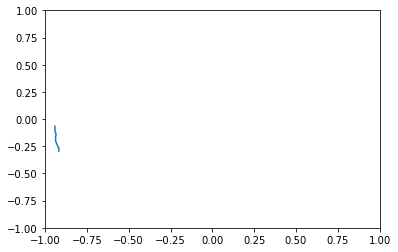

In [6]:
genny = DatasetMaker()
r, v = genny.generate_dataset(1, timesteps)
plt.plot(*r.detach().numpy().T)
plt.axis([-1, 1, -1, 1])
plt.show()

In [7]:
loss_history = []
progress = tqdm(range(train_steps))
for i in progress: # train loop
    r, v = genny.generate_dataset(bs, timesteps, device = device)
    r_label = r[:,1:]
    loss = model.train_step(x = (v, r[:,0]), y = r_label, optimizer = optimizer)

    if i % 10 == 0:
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.000337: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [05:01<00:00, 166.09it/s]


Text(0, 0.5, 'Train Loss')

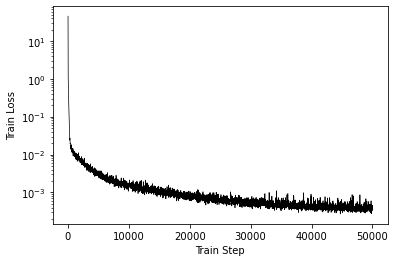

In [8]:
#loss_history = loss_history[1:]
plt.semilogy(np.arange(len(loss_history))*10, loss_history, "-k", linewidth = 0.7)
plt.xlabel("Train Step")
plt.ylabel("Train Loss")

In [9]:
r, v = genny.generate_dataset(5000, timesteps)
# inference
model.to("cpu")
p,_ = model.spatial_representation(v, model.p0(r[:,0])[None])
p = p.detach().numpy()

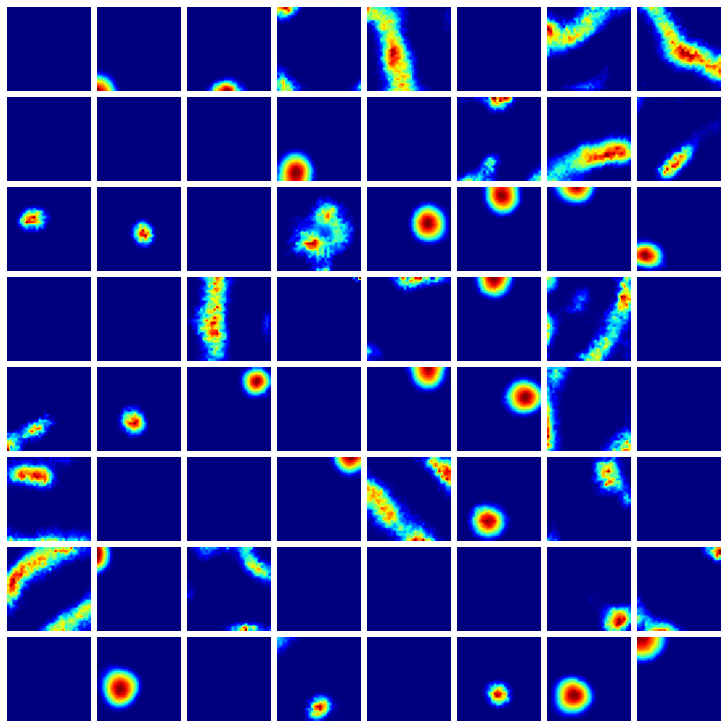

In [10]:
n_show = 8 # show all units in network

fig, ax = plt.subplots(n_show, n_show, figsize = (10,10), constrained_layout = True)

ps = p.reshape(-1, p.shape[-1])
rs = r[:,1:].detach().numpy().reshape(-1, 2)
ratemaps, _, _, _ = stats.binned_statistic_2d(rs[:,0], rs[:,1],ps.T, bins = 32)

for i in range(n_show**2):
    ax[i//n_show, i%n_show].imshow(ratemaps[i].T, origin = "lower", cmap = "jet")
    ax[i//n_show, i%n_show].axis("off")